In [2]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict
from statsmodels.stats.proportion import proportions_ztest

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter


import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [42]:
X = pd.read_csv('BXD-STR-Mutator-Manuscript/outs/denovo_ri_gts_hom_chrX.tsv', sep='\t')
Y = pd.read_csv('BXD-STR-Mutator-Manuscript/outs/denovo_ri_gts_homY.tsv', sep='\t')
auto = pd.read_csv('BXD-STR-Mutator-Manuscript/data/denovo_info/denovo_ri_gts_hom.tsv', sep='\t')
motif_info = pd.read_csv('BXD-STR-Mutator-Manuscript/outs/motif_info.csv')
calls_info = pd.read_csv('BXD-STR-Mutator-Manuscript/outs/all_repcn_proc_nosegdup_nolowcr_segreg.csv')
chr13_gt = pd.read_csv('BXD-STR-Mutator-Manuscript/outs/fou_gt_at_peak_chr13.tsv', sep='\t')
strains_info = pd.read_csv('BXD-STR-Mutator-Manuscript/outs/strain_info.csv')
founder_labels = pd.read_csv('Rerun/BXD-STR-Mutator-Manuscript/outs/all_foulab_nosegdup_nolowcr_noalshared_padded_imp.csv')


In [97]:
num_mut = auto.groupby(["chr", "pos"]).size().to_frame('num_mut')
auto_info = pd.merge(auto, num_mut, on=['chr', 'pos'])
auto_info['ref_len'] = auto_info.apply(lambda x: x.end - x.pos + 1, axis=1)
auto_info = pd.merge(auto_info, motif_info[["chr","pos","end","motif","motif_len"]], on=["chr","pos","end"])

In [68]:
calls_info_missing = calls_info.iloc[:, 0:3]
calls_info_D = calls_info[list(chr13_gt[chr13_gt['fou_gt']=='D']['strain'])]
calls_info_missing.insert(3, 'missing_D', calls_info_D.isnull().sum(axis=1))
calls_info_missing['calls_D'] = calls_info_missing['missing_D'].apply(lambda x: len(calls_info_D.columns) - x )

calls_info_B = calls_info[list(chr13_gt[chr13_gt['fou_gt']=='B']['strain'])]
calls_info_missing.insert(5, 'missing_B', calls_info_B.isnull().sum(axis=1))
calls_info_missing['calls_B'] = calls_info_missing['missing_B'].apply(lambda x: len(calls_info_B.columns) - x )

# auto_info = pd.merge(auto_info, calls_info_missing, on=["chr","pos","end"])

In [98]:
auto_info = pd.merge(auto_info, chr13_gt[['strain', 'fou_gt']], on=['strain'])
auto_info.rename(columns = {'fou_gt_y':'fou_gt_chr13'}, inplace = True)

In [12]:
calls_info['chr_pos'] = calls_info.apply(lambda x: f'{x.chr}_{x.pos}', axis=1)
founder_labels['chr_pos'] = founder_labels.apply(lambda x: f'{x.chr}_{x.pos}', axis=1)

calls_info = calls_info[calls_info.chr_pos.isin(founder_labels.chr_pos)]
founder_labels = founder_labels[founder_labels.chr_pos.isin(calls_info.chr_pos)]
calls_info = calls_info.sort_values(['chr', 'pos'])
founder_labels = founder_labels.sort_values(['chr', 'pos'])

In [14]:
calls_BB = []
missing_BB = []
calls_DD = []
missing_DD = []
calls_BD = []
missing_BD = []
calls_DB = []
missing_DB = []


D_chr13 = list(chr13_gt[chr13_gt['fou_gt']=='D']['strain'])
B_chr13 = list(chr13_gt[chr13_gt['fou_gt']=='B']['strain'])

for index, row in calls_info.iterrows():
    B_col = founder_labels.columns[[x=='B' for x in founder_labels.iloc[index]]]
    D_col = founder_labels.columns[[x=='D' for x in founder_labels.iloc[index]]]
    BB_col = list(set(B_col) & set(B_chr13))
    DD_col = list(set(D_col) & set(D_chr13))
    BD_col = list(set(B_col) & set(D_chr13))
    DB_col = list(set(D_col) & set(B_chr13))

    calls_BB.append(row[BB_col].notnull().sum())
    missing_BB.append(row[BB_col].isnull().sum())
    calls_DD.append(row[DD_col].notnull().sum())
    missing_DD.append(row[DD_col].isnull().sum())
    calls_BD.append(row[BD_col].notnull().sum())
    missing_BD.append(row[BD_col].isnull().sum())
    calls_DB.append(row[DB_col].notnull().sum())
    missing_DB.append(row[DB_col].isnull().sum())


In [59]:
calls_info_missing.insert(7,'calls_BB', calls_BB)
calls_info_missing.insert(8,'missing_BB', missing_BB)
calls_info_missing.insert(9,'calls_DD', calls_DD)
calls_info_missing.insert(10,'missing_DD', missing_DD)
calls_info_missing.insert(11,'calls_BD', calls_BD)
calls_info_missing.insert(12,'missing_BD', missing_BD)
calls_info_missing.insert(13,'calls_DB', calls_DB)
calls_info_missing.insert(14,'missing_DB', missing_DB)

In [60]:
calls_info_missing

,chr,pos,end,missing_D,calls_D,missing_B,calls_B,calls_BB,missing_BB,calls_DD,missing_DD,calls_BD,missing_BD,calls_DB,missing_DB
0,chr1,3068357,3068368,3,66,7,76,41,5,34,2,30,1,35,2
1,chr1,3086953,3086967,15,54,14,69,43,3,26,10,26,5,26,11
2,chr1,3095926,3095945,0,69,2,81,46,0,36,0,31,0,35,2
3,chr1,3134119,3134160,9,60,13,70,40,6,32,4,26,5,30,7
4,chr1,3162873,3162884,10,59,15,68,37,9,31,5,26,5,31,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45140,chr9,124318653,124318672,13,56,13,70,28,7,33,4,21,9,42,5
45141,chr9,124404678,124404695,8,61,7,76,30,5,34,3,25,5,45,2
45142,chr9,124424009,124424020,2,67,4,79,35,0,36,1,29,1,43,4
45143,chr9,124430277,124430312,2,67,1,82,34,1,36,1,29,1,46,0


In [99]:
auto_info = pd.merge(auto_info, calls_info_missing, on=["chr","pos","end"])
auto_info = pd.merge(auto_info, chr13_gt[['strain', 'fou_gt']], on=['strain'])
auto_info.rename(columns = {'fou_gt_y':'fou_gt_chr13'}, inplace = True)


In [100]:
def expan_perc(group):
    expand_type = group['expand_type']
    num_expan = (expand_type == 'expan').sum()
    return num_expan/len(expand_type)

def num_B(group):
    gt = group['fou_gt_chr13']
    num_B = (gt == 'B').sum()
    return num_B

def num_D(group):
    gt = group['fou_gt_chr13']
    num_D = (gt == 'D').sum()
    return num_D

def num_B_founder(group):
    gt = group['founder']
    num_B = (gt == 'B').sum()
    return num_B

def num_D_founder(group):
    gt = group['founder']
    num_D = (gt == 'D').sum()
    return num_D

def num_BD_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_BD = ((gt == 'B')&(gt13 =='D')).sum()
    return num_BD

def num_DD_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_DD = ((gt == 'D')&(gt13 =='D')).sum()
    return num_DD

def num_BB_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_BB = ((gt == 'B')&(gt13 =='B')).sum()
    return num_BB

def num_DB_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_DB = ((gt == 'D')&(gt13 =='B')).sum()
    return num_DB

def num_expan(group):
    expand_type = group['expand_type']
    num_expan = (expand_type == 'expan').sum()
    return num_expan

def num_contr(group):
    expand_type = group['expand_type']
    num_contr = (expand_type == 'contr').sum()
    return num_contr

In [101]:
grouped_mut = auto_info.groupby(["chr", "pos"])

expan_perc = grouped_mut.apply(expan_perc).to_frame('expan_perc')
auto_info = pd.merge(auto_info, expan_perc, on=['chr', 'pos'])

num_B = grouped_mut.apply(num_B).to_frame('num_B')
auto_info = pd.merge(auto_info, num_B, on=['chr', 'pos'])
num_D = grouped_mut.apply(num_D).to_frame('num_D')
auto_info = pd.merge(auto_info, num_D, on=['chr', 'pos'])

num_B_founder = grouped_mut.apply(num_B_founder).to_frame('num_B_founder')
auto_info = pd.merge(auto_info, num_B_founder, on=['chr', 'pos'])
num_D_founder = grouped_mut.apply(num_D_founder).to_frame('num_D_founder')
auto_info = pd.merge(auto_info, num_D_founder, on=['chr', 'pos'])

In [102]:
num_DD = grouped_mut.apply(num_DD_founder_gt13).to_frame('num_DD')
auto_info = pd.merge(auto_info, num_DD, on=['chr', 'pos'])

num_DB = grouped_mut.apply(num_DB_founder_gt13).to_frame('num_DB')
auto_info = pd.merge(auto_info, num_DB, on=['chr', 'pos'])

num_BD = grouped_mut.apply(num_BD_founder_gt13).to_frame('num_BD')
auto_info = pd.merge(auto_info, num_BD, on=['chr', 'pos'])

num_BB = grouped_mut.apply(num_BB_founder_gt13).to_frame('num_BB')
auto_info = pd.merge(auto_info, num_BB, on=['chr', 'pos'])

In [103]:
num_expan_grp = grouped_mut.apply(num_expan).to_frame('num_expan')
auto_info = pd.merge(auto_info, num_expan_grp, on=['chr', 'pos'])
num_contr = grouped_mut.apply(num_contr).to_frame('num_contr')
auto_info = pd.merge(auto_info, num_contr, on=['chr', 'pos'])

In [22]:
# expan_B, contr_B, expan_D, contr_D
expan_dict = defaultdict(lambda: [0,0,0,0])
# expan_BB, contr_BB, expan_DD, contr_DD, expan_BD, contr_BD, expan_DB, contr_DB
expan_gt13founder_dict = defaultdict(lambda: [0,0,0,0, 0,0,0,0])

expan_sizes_B = defaultdict(list)
expan_sizes_D = defaultdict(list)

for index, row in auto_info.iterrows():
    pos = f"{row['chr']}_{row['pos']}"
    if row['fou_gt_chr13'] == 'B':
        expan_sizes_B[pos].append(row['delta_fou']*row['expand_sign'])
        if row['expand_type'] == 'expan':
            expan_dict[pos][0] += 1
            #BB
            if row['founder'] =='B':
                expan_gt13founder_dict[pos][0] += 1
            #DB
            else: 
                expan_gt13founder_dict[pos][6] += 1
        #contractions
        else:
            expan_dict[pos][1] += 1
            if row['founder'] =='B':
                expan_gt13founder_dict[pos][1] += 1
            else: 
                expan_gt13founder_dict[pos][7] += 1
    else:
        expan_sizes_D[pos].append(row['delta_fou']*row['expand_sign'])
        if row['expand_type'] == 'expan':
            expan_dict[pos][2] += 1
            #DD
            if row['founder'] =='D':
                expan_gt13founder_dict[pos][2] += 1
            #BD
            else: 
                expan_gt13founder_dict[pos][4] += 1
        else:
            expan_dict[pos][3] += 1
            if row['founder'] =='D':
                expan_gt13founder_dict[pos][3] += 1
            else: 
                expan_gt13founder_dict[pos][5] += 1
    

In [104]:
calls_founder = calls_info[['chr', 'pos', 'end', 'DBA', 'C57BL']]
calls_founder['DBA'] = calls_founder['DBA'].fillna(-1)
calls_founder['DBA'] = calls_founder['DBA'].apply(lambda x: int(str(x).split(',')[0]))
calls_founder['C57BL'] = calls_founder['C57BL'].fillna(-1)
calls_founder['C57BL'] = calls_founder['C57BL'].apply(lambda x: int(str(x).split(',')[0]))
auto_info = pd.merge(auto_info, calls_founder, on=['chr', 'pos', 'end'])


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [105]:
# expan_B, contr_B, expan_D, contr_D

# expan_BB, contr_BB, expan_DD, contr_DD, expan_BD, contr_BD, expan_DB, contr_DB

auto_info['expan_B'] = 0
auto_info['contr_B'] = 0
auto_info['expan_D'] = 0
auto_info['contr_D'] = 0
auto_info['expan_sizes_B'] = np.empty((len(auto_info), 0)).tolist()
auto_info['expan_sizes_D'] = np.empty((len(auto_info), 0)).tolist()

auto_info['expan_BB'] = 0
auto_info['contr_BB'] = 0
auto_info['expan_DD'] = 0
auto_info['contr_DD'] = 0
auto_info['expan_BD'] = 0
auto_info['contr_BD'] = 0
auto_info['expan_DB'] = 0
auto_info['contr_DB'] = 0

for index, row in auto_info.iterrows():
    pos = f"{row['chr']}_{row['pos']}"
    auto_info.at[index, 'expan_B'] = expan_dict[pos][0]
    auto_info.at[index, 'contr_B'] = expan_dict[pos][1]
    auto_info.at[index, 'expan_D'] = expan_dict[pos][2]
    auto_info.at[index, 'contr_D'] = expan_dict[pos][3]
    auto_info.at[index, 'expan_sizes_B'] = expan_sizes_B[pos]
    auto_info.at[index, 'expan_sizes_D'] = expan_sizes_D[pos]
    
    auto_info.at[index, 'expan_BB'] = expan_gt13founder_dict[pos][0]
    auto_info.at[index, 'contr_BB'] = expan_gt13founder_dict[pos][1]
    auto_info.at[index, 'expan_DD'] = expan_gt13founder_dict[pos][2]
    auto_info.at[index, 'contr_DD'] = expan_gt13founder_dict[pos][3]

    auto_info.at[index, 'expan_BD'] = expan_gt13founder_dict[pos][4]
    auto_info.at[index, 'contr_BD'] = expan_gt13founder_dict[pos][5]
    auto_info.at[index, 'expan_DB'] = expan_gt13founder_dict[pos][6]
    auto_info.at[index, 'contr_DB'] = expan_gt13founder_dict[pos][7]

In [106]:
auto_info_uncollapsed = auto_info.copy()
auto_info_uncollapsed = auto_info_uncollapsed.drop(['num_mut', 'missing_D', 'calls_D', 
       'missing_B', 'calls_B', 'calls_BB', 'missing_BB', 'calls_DD', 
       'missing_DD', 'calls_BD', 'missing_BD', 'calls_DB', 'missing_DB','num_B', 'num_D', 'num_B_founder', 
       'num_D_founder', 'num_DD', 'num_DB', 'num_BD', 'num_BB', 'num_expan', 
       'num_contr','expan_B', 'contr_B', 'expan_D', 'contr_D', 
       'expan_sizes_B', 'expan_sizes_D', 'expan_BB', 'contr_BB', 'expan_DD', 
       'contr_DD', 'expan_BD', 'contr_BD', 'expan_DB', 'contr_DB', 'expan_perc'], axis=1)

auto_info_uncollapsed = auto_info_uncollapsed[['chr',
 'pos',
 'end',
 'strain',
 'RN_A',
 'RN_B',
 'founder',
 'fou_het',
 'fou_gt_x',
 'fou_rn',
 'delta_fou',
 'expand_sign',
 'expand_type',
 'motif',
 'motif_len',
 'fou_gt',
 'fou_gt_chr13',
 'DBA',
 'C57BL']]
# auto_info_uncollapsed.to_csv('BXD-STR-Mutator-Manuscript/outs/SupplementaryDataset1.txt' ,sep='\t', index=False)


In [107]:
auto_info_collapsed = auto_info.copy()
auto_info_collapsed = auto_info_collapsed[['chr', 'pos', 'end', 'motif',
       'motif_len', 'num_mut', 'num_B', 'num_D', 'num_B_founder',
       'num_D_founder', 'num_DD', 'num_DB', 'num_BD', 'num_BB', 'num_expan',
       'num_contr',  'expan_B', 'contr_B', 'expan_D', 'contr_D',
       'expan_sizes_B', 'expan_sizes_D', 'expan_BB', 'contr_BB', 'expan_DD',
       'contr_DD', 'expan_BD', 'contr_BD', 'expan_DB', 'contr_DB', 'missing_D', 'calls_D', 'missing_B', 'calls_B', 'calls_BB',
       'missing_BB', 'calls_DD', 'missing_DD', 'calls_BD', 'missing_BD',
       'calls_DB', 'missing_DB', 'DBA', 'C57BL',]]
auto_info_collapsed = auto_info_collapsed.drop_duplicates(['chr','pos', 'end'])

# auto_info_collapsed.to_csv('BXD-STR-Mutator-Manuscript/outs/SupplementaryDataset2.txt' ,sep='\t', index=False)


In [108]:
auto_info

,chr,pos,end,strain,RN_A,RN_B,founder,fou_het,fou_gt_x,fou_rn,...,expan_sizes_B,expan_sizes_D,expan_BB,contr_BB,expan_DD,contr_DD,expan_BD,contr_BD,expan_DB,contr_DB
0,chr1,3134119,3134160,BXD184,15,15,D,False,14/14,14,...,[],[1],0,0,1,0,0,0,0,0
1,chr1,14863953,14863982,BXD184,7,7,D,False,6/6,6,...,[],"[1, 1]",0,0,2,0,0,0,0,0
2,chr1,14863953,14863982,BXD161,7,7,D,False,6/6,6,...,[],"[1, 1]",0,0,2,0,0,0,0,0
3,chr1,82254121,82254172,BXD184,14,14,D,False,13/13,13,...,[-1],"[1, -1]",0,1,1,1,0,0,0,0
4,chr1,82254121,82254172,BXD032,12,12,D,False,13/13,13,...,[-1],"[1, -1]",0,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54375,chr15,20010909,20010962,BXD221,8,8,B,False,9/9,9,...,[],[-1],0,0,0,0,0,1,0,0
54376,chr15,86661516,86661555,BXD221,11,11,B,False,10/10,10,...,[],[1],0,0,0,0,1,0,0,0
54377,chr16,7692498,7692513,BXD221,3,3,D,False,4/4,4,...,[],[-1],0,0,0,1,0,0,0,0
54378,chr18,66482437,66482492,BXD221,13,13,B,False,14/14,14,...,[],[-1],0,0,0,0,0,1,0,0


In [87]:
auto_info

,chr,pos,end,motif,motif_len,num_mut,num_B,num_D,num_B_founder,num_D_founder,...,calls_BB,missing_BB,calls_DD,missing_DD,calls_BD,missing_BD,calls_DB,missing_DB,DBA,C57BL
0,chr1,3134119,3134160,TTG,3,1,0,1,0,1,...,40,6,32,4,26,5,30,7,14,14
1,chr1,14863953,14863982,AGACAG,6,2,0,2,0,2,...,41,2,32,2,33,1,37,3,6,5
2,chr1,82254121,82254172,ATAA,4,3,1,2,1,2,...,24,8,35,7,14,4,30,7,13,13
3,chr1,89398099,89398134,TAGA,4,1,0,1,0,1,...,40,5,28,7,27,7,28,10,9,9
4,chr1,91406399,91406430,ATAG,4,55,30,25,1,54,...,38,10,25,9,31,3,30,4,10,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54375,chr15,20010909,20010962,ATAGAG,6,1,0,1,1,0,...,44,13,18,4,35,10,22,4,7,9
54376,chr15,86661516,86661555,AAAT,4,1,0,1,1,0,...,38,6,22,5,33,8,35,4,9,10
54377,chr16,7692498,7692513,TAAA,4,1,0,1,0,1,...,29,16,22,6,31,9,31,7,4,4
54378,chr18,66482437,66482492,CATC,4,1,0,1,1,0,...,26,6,22,12,24,11,32,19,14,14


In [88]:
# get mutations and drop these mutations from the master mutation df
mutations = set()
for index, row in auto_info.iterrows():
    mutations.add(f"{row['chr']}_{row['pos']}")
    
repeated_indices = []
for index, row in calls_info_missing.iterrows():
    pos = f"{row['chr']}_{row['pos']}"
    if pos in mutations:
        repeated_indices.append(index)
calls_info_missing_droprepeats = calls_info_missing.drop(calls_info_missing.index[repeated_indices])

In [89]:
calls_info_missing_droprepeats = pd.merge(calls_info_missing_droprepeats, motif_info[["chr","pos","end","motif","motif_len"]], on=["chr","pos","end"])
calls_info_missing_droprepeats = pd.merge(calls_info_missing_droprepeats, calls_founder, on=["chr","pos","end"])


In [92]:
calls_info_missing_all = calls_info_missing_droprepeats.copy()
calls_info_missing_all = pd.concat([auto_info_collapsed[['chr', 'pos', 'end', 'missing_D', 'calls_D', 'missing_B', 'calls_B',
       'calls_BB', 'missing_BB', 'calls_DD', 'missing_DD', 'calls_BD',
       'missing_BD', 'calls_DB', 'missing_DB', 'motif', 'motif_len', 'DBA',
       'C57BL']], calls_info_missing_all])
calls_info_missing_all = calls_info_missing_all.sort_values(['chr', 'pos'])
# calls_info_missing_all.to_csv('BXD-STR-Mutator-Manuscript/outs/SupplementaryDataset3.txt' ,sep='\t', index=False)


# Metrics Msh3GT (and period) and Founder GT

In [95]:
def GetFounderCall(fcall):
    if "," not in str(fcall): return np.nan
    a1, a2 = fcall.split(",")
    a1 = int(a1)
    a2 = int(a2)
    if a1 != a2: return np.nan
    return int(a1)

founder_labels.index = founder_labels.apply(lambda x: "%s:%s"%(x["chr"], x["pos"]), 1)
def GetParentLabel(founder_labels, chrom, pos, strain):
    return founder_labels.loc["%s:%s"%(chrom, pos), strain]
    #return founder_labels[(founder_labels["chr"]==chrom) & 
    #               (founder_labels["pos"]==pos)][strain].values[0]

calls_info["B"] = calls_info["C57BL"].apply(GetFounderCall)
calls_info["D"] = calls_info["DBA"].apply(GetFounderCall)

def GetNumCalls(calls_info, chr13_gt, motif_info, founder_labels, period, msh3, replen, filtset, founder="both"):
    # Add motif info
    df = pd.merge(calls_info, motif_info[["chr","pos","end","motif_len"]])
    # Restrict to period
    df = df[df["motif_len"]==period]
    # Remove filtered loci
    merged = pd.merge(df, filtset, how='outer', indicator=True)
    df = merged[merged['_merge'] == 'left_only']
    # Require either B or D matches parent allele
    df = df[(df["B"]==float(replen)) | (df["D"]==float(replen))]
    # Restrict to relevant strains
    strains = list(chr13_gt[chr13_gt["fou_gt"]==msh3]["strain"])
    df = df[["chr","pos","end","B","D"]+strains]
    # Go through each strain and each locus 
    #   If missing, continue
    #   Retrieve parent label. 
    #   If parent label doesn't match $founder, continue
    #   If parent length matches replen, add 1
    # TODO could adjust for num generations inbreeding here
    total_mut = 0
    for i in range(df.shape[0]):
        for strain in strains:
            call = df[strain].values[i]
            if str(call) == "nan":
                continue
            parent = GetParentLabel(founder_labels, df["chr"].values[i], df["pos"].values[i], strain)
            if (founder != "both") and (parent != founder): continue
            # if parent length matches replen, add 1 to total_mu
            parent_len = np.nan
            if parent == "B": parent_len = df["B"].values[i]
            elif parent == "D": parent_len = df["D"].values[i]
            else:
                continue # parent nan
            if parent_len == replen: total_mut += 1
    return total_mut

# # Test this out
# filtset = auto_info[auto_info["num_mut"]>=10][["chr","pos"]].copy()
# replen=10
# GetNumCalls(calls_info, chr13_gt, motif_info, founder_labels, period, msh3, replen, filtset, founder="both")

mut_rate 2 3
mut_rate 2 4
mut_rate 2 5
mut_rate 2 6
mut_rate 2 7
mut_rate 2 8
mut_rate 2 9
mut_rate 2 10
mut_rate 2 11
mut_rate 2 12
mut_rate 2 13
mut_rate 2 14
mut_rate 2 15
mut_rate 2 16
mut_rate 2 17
mut_rate 2 18
mut_rate 2 19
mut_rate 2 20
mut_rate 2 3
mut_rate 2 4
mut_rate 2 5
mut_rate 2 6
mut_rate 2 7
mut_rate 2 8
mut_rate 2 9
mut_rate 2 10
mut_rate 2 11
mut_rate 2 12
mut_rate 2 13
mut_rate 2 14
mut_rate 2 15
mut_rate 2 16
mut_rate 2 17
mut_rate 2 18
mut_rate 2 19
mut_rate 2 20
mut_rate 3 3
mut_rate 3 4
mut_rate 3 5
mut_rate 3 6
mut_rate 3 7
mut_rate 3 8
mut_rate 3 9
mut_rate 3 10
mut_rate 3 11
mut_rate 3 12
mut_rate 3 13
mut_rate 3 14
mut_rate 3 15
mut_rate 3 16
mut_rate 3 17
mut_rate 3 18
mut_rate 3 19
mut_rate 3 20
mut_rate 3 3
mut_rate 3 4
mut_rate 3 5
mut_rate 3 6
mut_rate 3 7
mut_rate 3 8
mut_rate 3 9
mut_rate 3 10
mut_rate 3 11
mut_rate 3 12
mut_rate 3 13
mut_rate 3 14
mut_rate 3 15
mut_rate 3 16
mut_rate 3 17
mut_rate 3 18
mut_rate 3 19
mut_rate 3 20
mut_rate 4 3
mut_rat

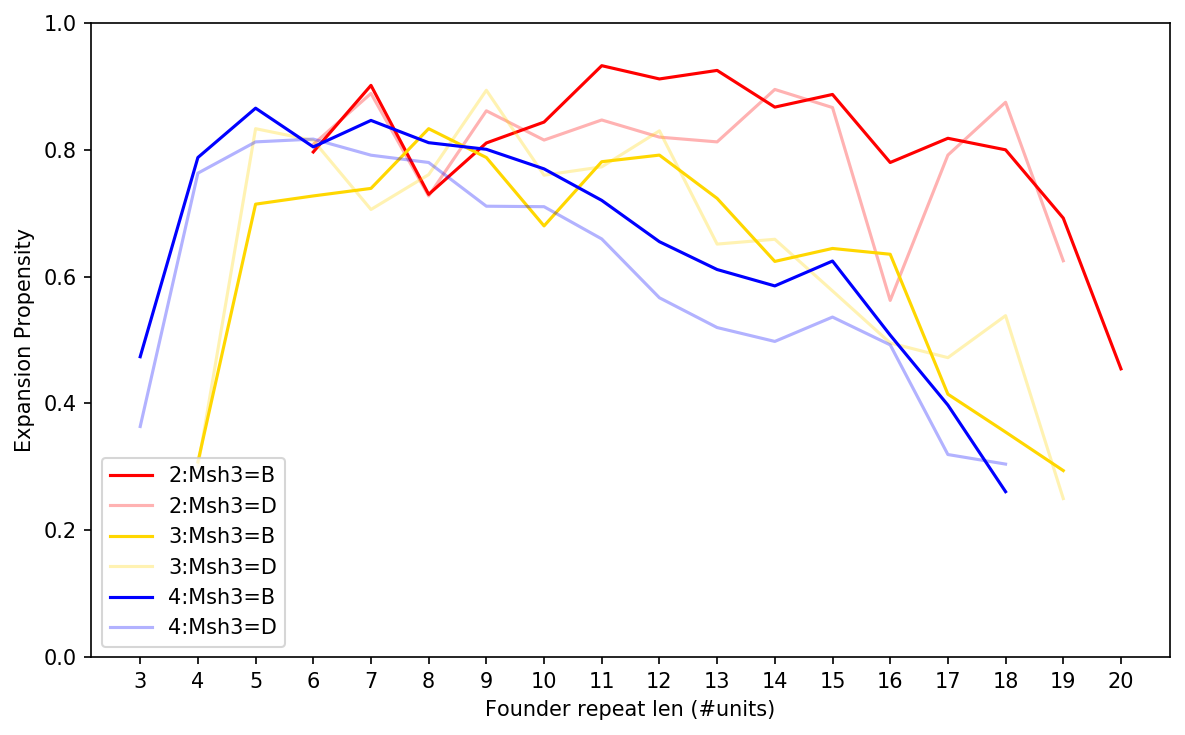

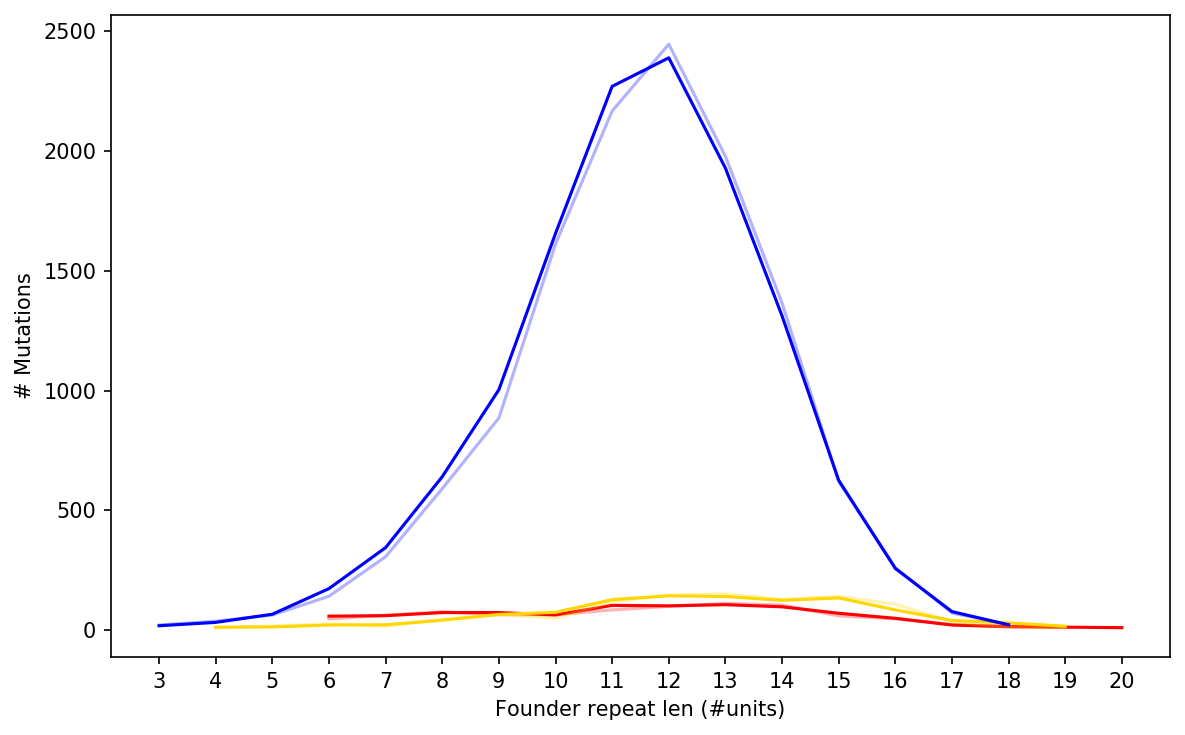

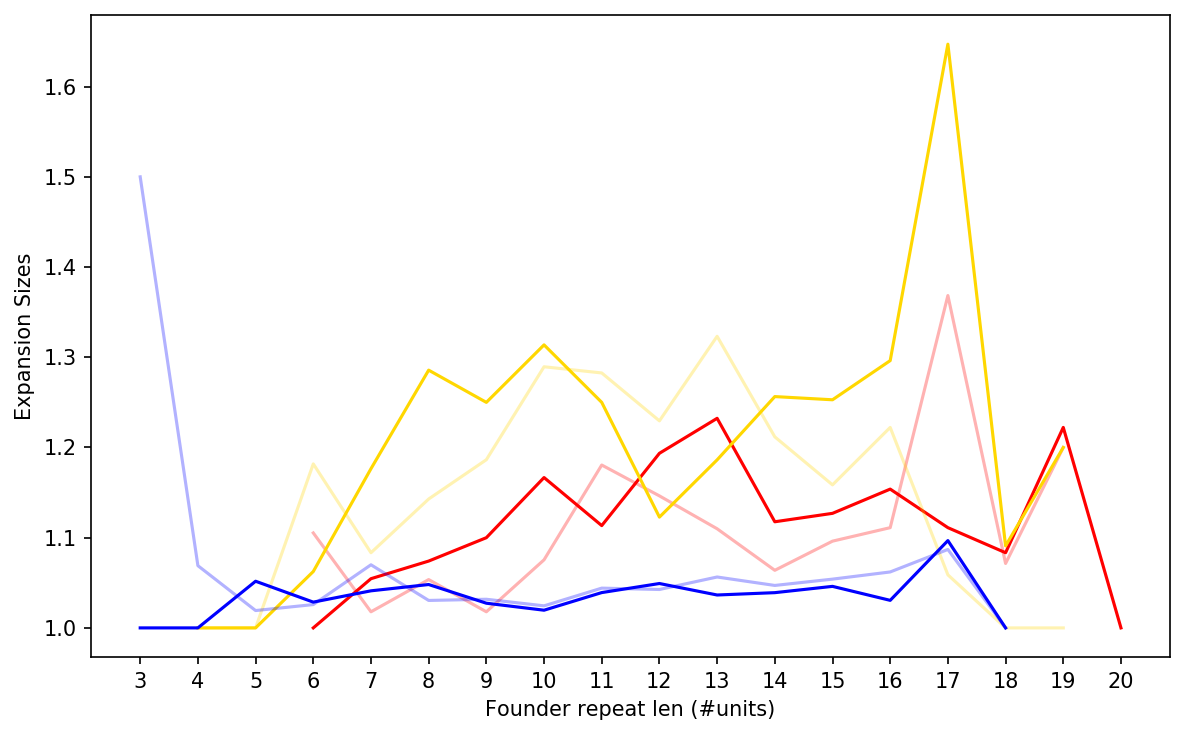

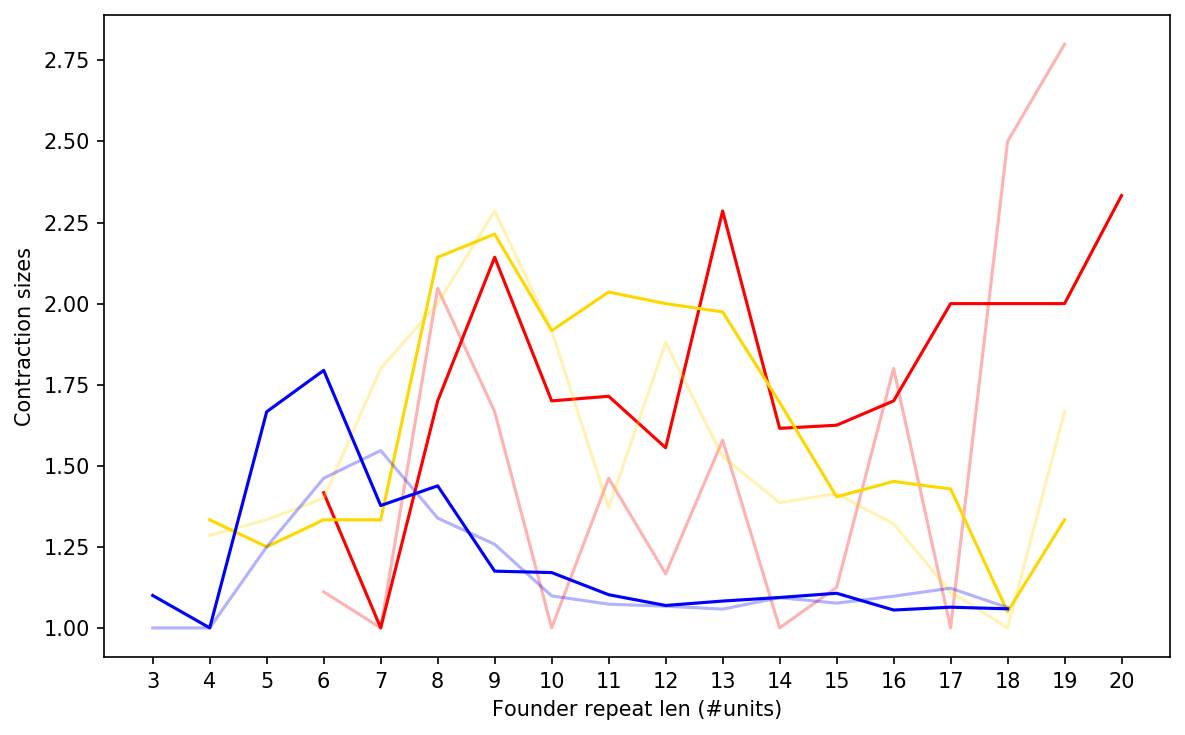

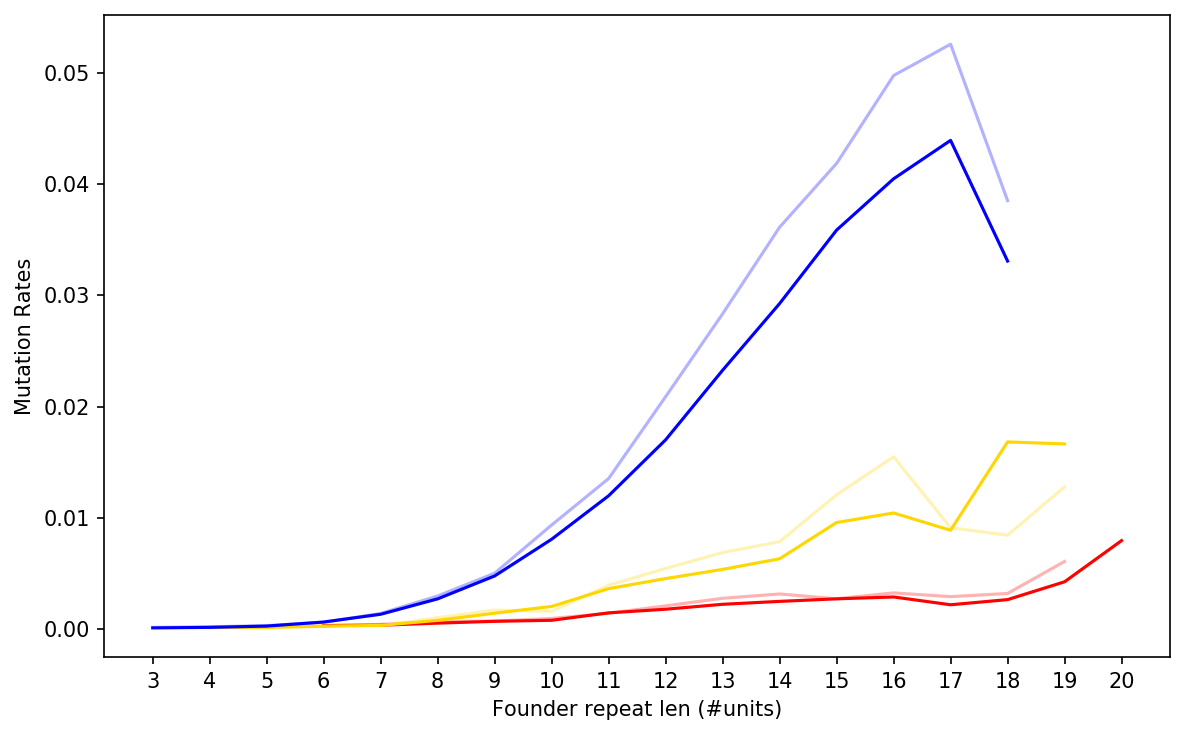

In [109]:
### Color schemes 
# di: red
# tri: gold
# tetra: glue
# Msh3B=dark, Msh3D=light
# founderB=solid, founderD=dashed

def MakePatternPlot_Combined(auto_info, metric, \
                             calls_info=None, chr13_gt=None, motif_info=None, founder_labels=None):
    titles = {"exp_prop": "Expansion Propensity", "num_mut": "# Mutations", "contr_size": "Contraction sizes", "exp_size": "Expansion Sizes", "mut_rate": "Mutation Rates"}
    percolors = {2: "red", 3: "gold", 4: "blue"}
    msh3line = {"B": 1, "D": 0.3}
    MINREP = 3 # min repeat length
    MAXREP = 20 # max repeat length

    fig = plt.figure(dpi=150)
    fig.set_size_inches((8, 5))
    ax = fig.add_subplot(111)
    for period in [2, 3, 4]:
        color = percolors[period]
        for msh3 in ["B", "D"]:
            alpha = msh3line[msh3]
            y_values = []
            for replen in range(MINREP, MAXREP+1):
                if metric == "mut_rate": print("%s %s %s"%(metric, period, replen))
                muts = auto_info[(auto_info["motif_len"]==period) & \
                                 (auto_info["fou_gt_chr13"]==msh3) & \
                                (auto_info["fou_rn"]==replen) & \
                                (auto_info["num_mut"]<10)].copy()
                if muts.shape[0] < 10:
                    y_values.append(float("nan"))
                else:
                    if metric == "exp_prop":
                        y_values.append(np.mean(muts["expand_sign"].apply(lambda x: x==1)))
                    elif metric == "num_mut":
                        y_values.append(muts.shape[0])
                    elif metric == "contr_size": # filter out large mutations
                        y_values.append(np.mean(muts[(muts["expand_sign"]==-1) & (muts["delta_fou"]<=5)]["delta_fou"]))
                    elif metric == "exp_size":
                        y_values.append(np.mean(muts[(muts["expand_sign"]==1)  & (muts["delta_fou"]<=5)]["delta_fou"]))
                    elif metric == "mut_rate": 
                        filtset = auto_info[auto_info["num_mut"]>=10][["chr","pos"]].copy()
                        numcalls = GetNumCalls(calls_info, chr13_gt, motif_info, founder_labels, period, msh3, replen, filtset, founder="both")
                        y_values.append(muts.shape[0]/numcalls)
                    else:
                        y_values.append(float("nan"))
            ax.plot(range(MINREP, MAXREP+1), y_values, \
                     color=color, alpha=alpha, \
                    label="%s:Msh3=%s"%(period, msh3))       
        ax.set_xlabel("Founder repeat len (#units)")
        ax.set_ylabel(titles[metric])
        ax.set_xticks(range(MINREP, MAXREP+1));
        if metric == "exp_prop":
            ax.set_ylim(bottom=0, top=1)
            ax.legend(loc="lower left");
    fig.tight_layout()
    fig.savefig("%s-combined.pdf"%metric)
    
MakePatternPlot_Combined(auto_info, "exp_prop")
# plt.savefig('figs/Figure2f_v2.pdf') 
MakePatternPlot_Combined(auto_info, "num_mut")
# plt.savefig('figs/SuppFig_nummut.pdf') 
MakePatternPlot_Combined(auto_info, "exp_size")
# plt.savefig('figs/SuppFig_expsize.pdf') 
MakePatternPlot_Combined(auto_info, "contr_size")
# plt.savefig('figs/SuppFig_contrsize.pdf') 

MakePatternPlot_Combined(auto_info, "mut_rate", calls_info=calls_info, \
                         chr13_gt=chr13_gt, motif_info=motif_info, founder_labels=founder_labels)
# plt.savefig('figs/Figure2e_v2.pdf') 



mut_rate 2 3
mut_rate 2 4
mut_rate 2 5
mut_rate 2 6
mut_rate 2 7
mut_rate 2 8
mut_rate 2 9
mut_rate 2 10
mut_rate 2 11
mut_rate 2 12
mut_rate 2 13
mut_rate 2 14
mut_rate 2 15
mut_rate 2 16
mut_rate 2 17
mut_rate 2 18
mut_rate 2 19
mut_rate 2 20
mut_rate 2 3
mut_rate 2 4
mut_rate 2 5
mut_rate 2 6
mut_rate 2 7
mut_rate 2 8
mut_rate 2 9
mut_rate 2 10
mut_rate 2 11
mut_rate 2 12
mut_rate 2 13
mut_rate 2 14
mut_rate 2 15
mut_rate 2 16
mut_rate 2 17
mut_rate 2 18
mut_rate 2 19
mut_rate 2 20
mut_rate 2 3
mut_rate 2 4
mut_rate 2 5
mut_rate 2 6
mut_rate 2 7
mut_rate 2 8
mut_rate 2 9
mut_rate 2 10
mut_rate 2 11
mut_rate 2 12
mut_rate 2 13
mut_rate 2 14
mut_rate 2 15
mut_rate 2 16
mut_rate 2 17
mut_rate 2 18
mut_rate 2 19
mut_rate 2 20
mut_rate 2 3
mut_rate 2 4
mut_rate 2 5
mut_rate 2 6
mut_rate 2 7
mut_rate 2 8
mut_rate 2 9
mut_rate 2 10
mut_rate 2 11
mut_rate 2 12
mut_rate 2 13
mut_rate 2 14
mut_rate 2 15
mut_rate 2 16
mut_rate 2 17
mut_rate 2 18
mut_rate 2 19
mut_rate 2 20
mut_rate 3 3
mut_rat

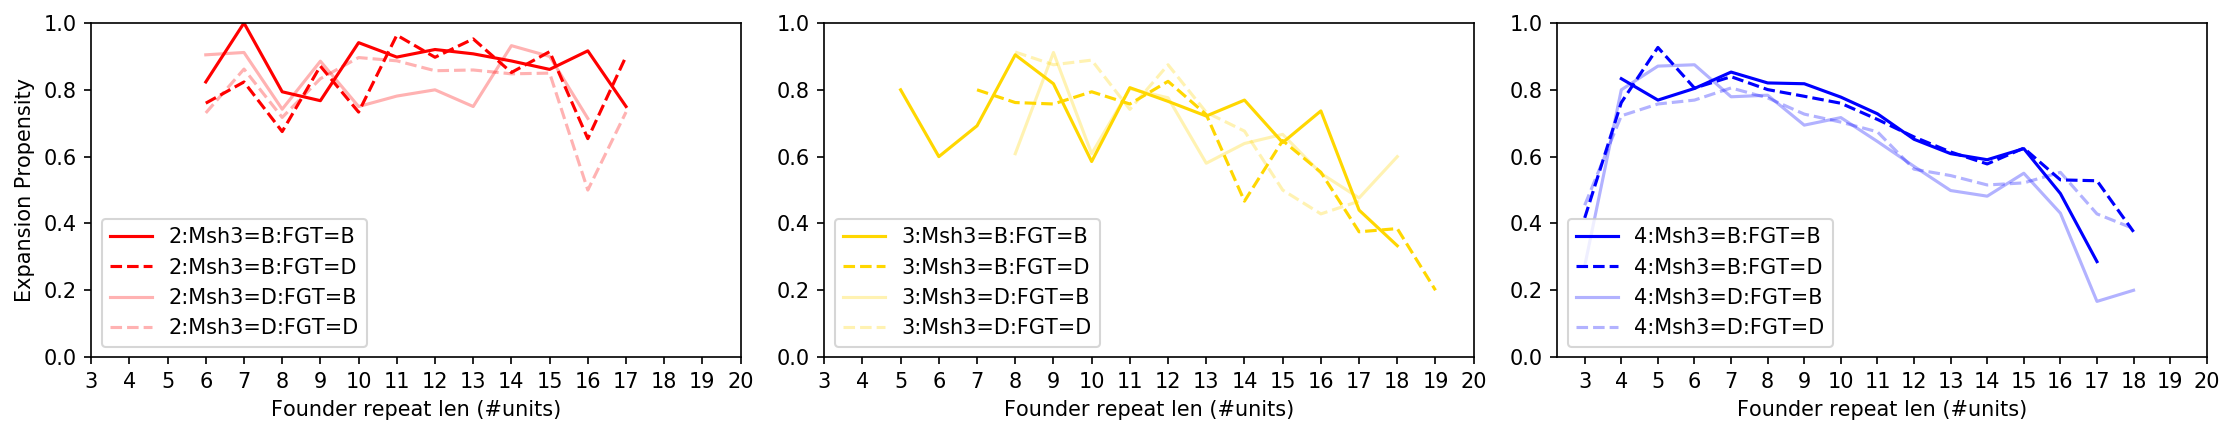

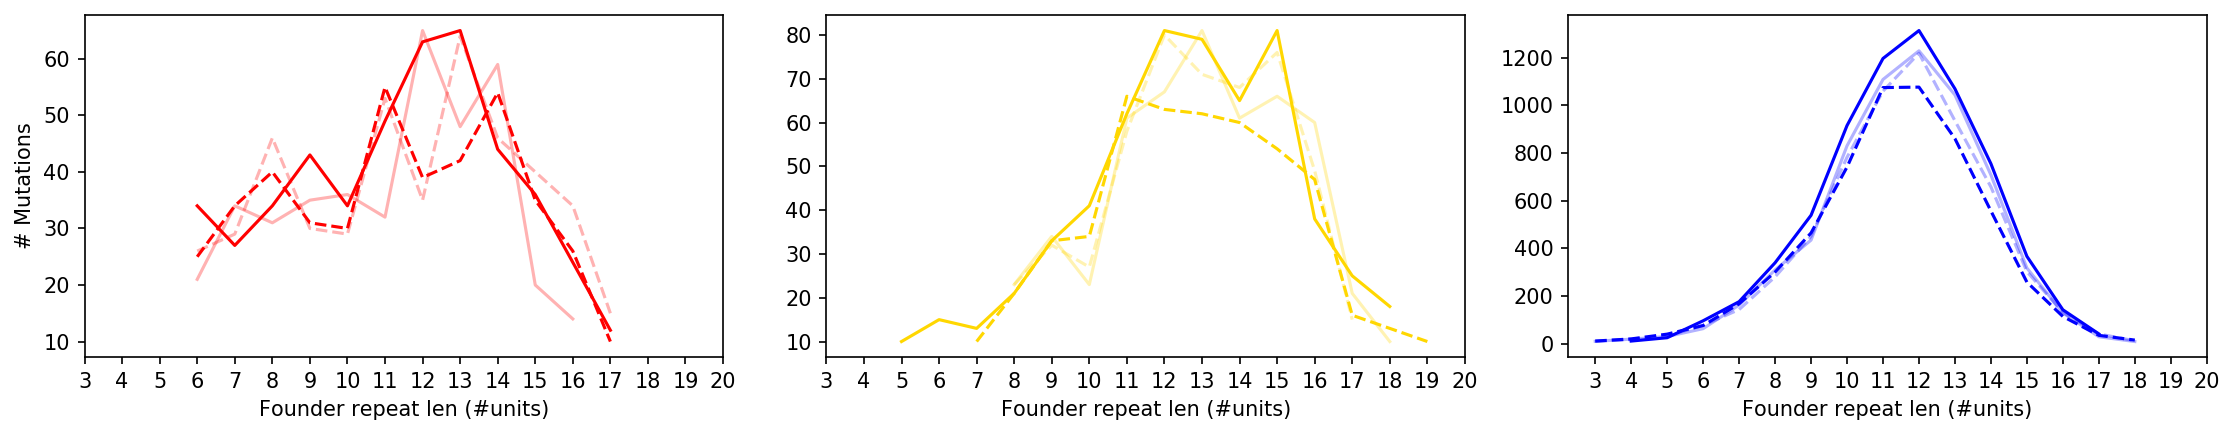

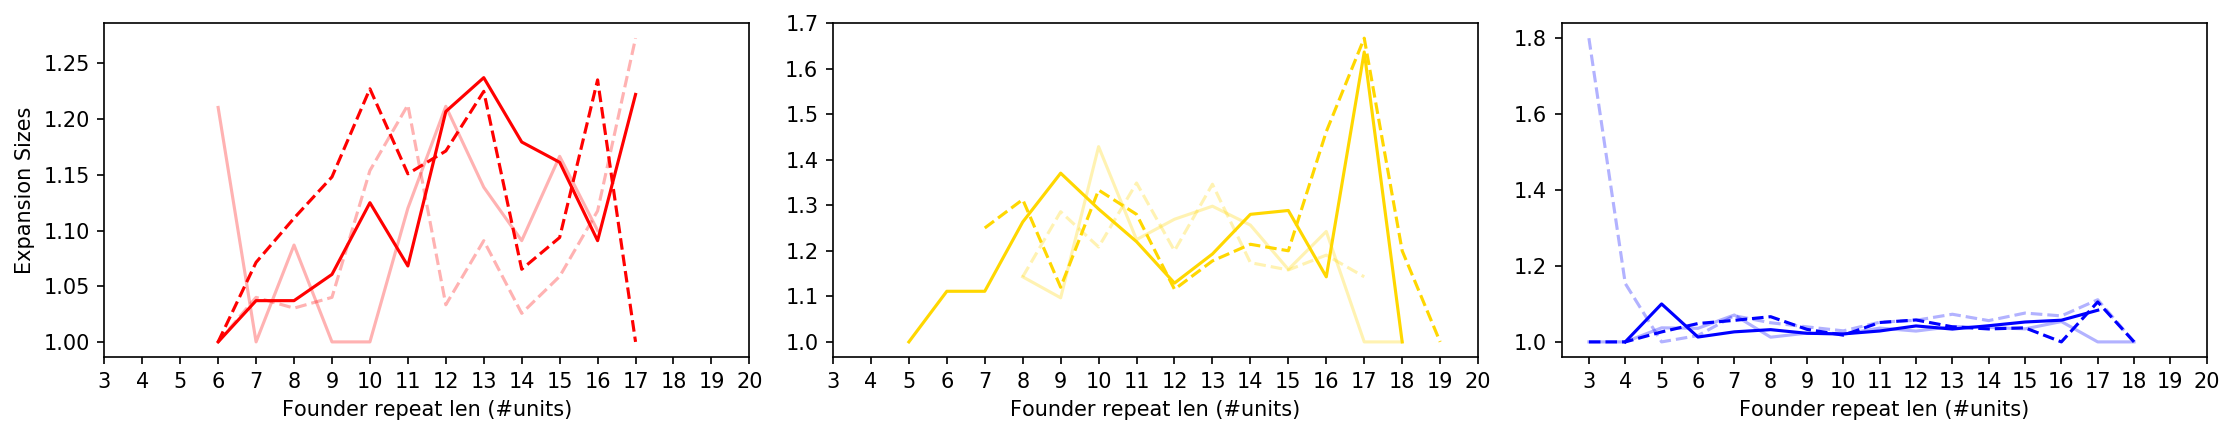

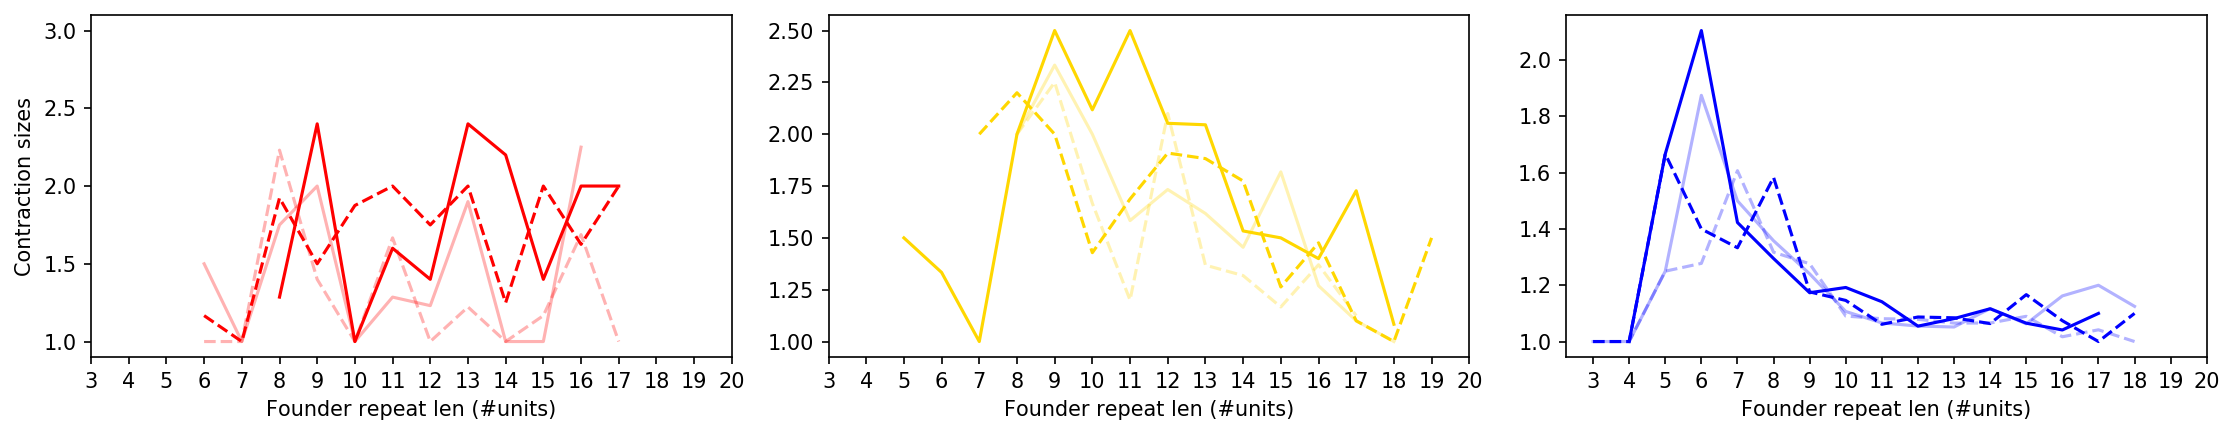

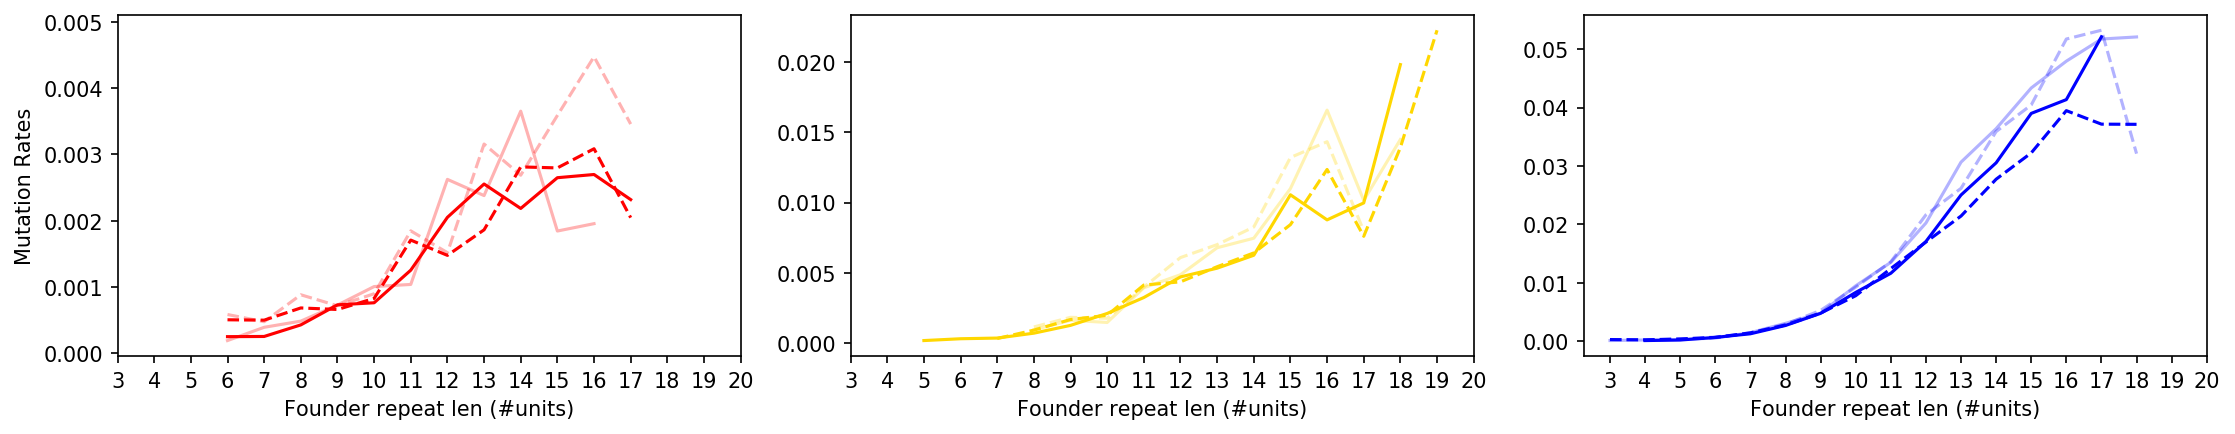

In [111]:
### Color schemes 
# di: red
# tri: gold
# tetra: glue
# Msh3B=dark, Msh3D=light
# founderB=solid, founderD=dashed

def MakePatternPlot_ByFounder(auto_info, metric, \
                             calls_info=None, chr13_gt=None, motif_info=None, founder_labels=None):
    titles = {"exp_prop": "Expansion Propensity", "num_mut": "# Mutations", "contr_size": "Contraction sizes", "exp_size": "Expansion Sizes", "mut_rate": "Mutation Rates"}
    percolors = {2: "red", 3: "gold", 4: "blue"}
    msh3line = {"B": 1, "D": 0.3}
    fouline = {"B": "solid", "D": "dashed"}
    MINREP = 3 # min repeat length
    MAXREP = 20 # max repeat length

    fig = plt.figure(dpi=150)
    fig.set_size_inches((15, 3))
    for period in [2, 3, 4]:
        ax1 = fig.add_subplot(1, 3, period-1)
        color = percolors[period]
        for msh3 in ["B", "D"]:
            alpha = msh3line[msh3]
            for founderGT in ["B", "D"]:
                ltype = fouline[founderGT]
                y_values = []
                for replen in range(MINREP, MAXREP+1):
                    if metric == "mut_rate": print("%s %s %s"%(metric, period, replen))
                    muts = auto_info[(auto_info["motif_len"]==period) & \
                                 (auto_info["fou_gt_chr13"]==msh3) & \
                                 (auto_info["founder"]==founderGT) & \
                                (auto_info["fou_rn"]==replen) & \
                                (auto_info["num_mut"]<10)].copy()
                    if muts.shape[0] < 10:
                        y_values.append(float("nan"))
                    else:
                        if metric == "exp_prop":
                            y_values.append(np.mean(muts["expand_sign"].apply(lambda x: x==1)))
                        elif metric == "num_mut":
                            y_values.append(muts.shape[0])
                        elif metric == "contr_size": # filter out large mutations
                            y_values.append(np.mean(muts[(muts["expand_sign"]==-1) & (muts["delta_fou"]<=5)]["delta_fou"]))
                        elif metric == "exp_size":
                            y_values.append(np.mean(muts[(muts["expand_sign"]==1)  & (muts["delta_fou"]<=5)]["delta_fou"]))
                        elif metric == "mut_rate":
                            filtset = auto_info[auto_info["num_mut"]>=10][["chr","pos"]].copy()
                            numcalls = GetNumCalls(calls_info, chr13_gt, motif_info, \
                                                   founder_labels, period, msh3, replen, \
                                                   filtset, founder=founderGT)
                            y_values.append(muts.shape[0]/numcalls)
                        else:
                            y_values.append(float("nan"))
                ax1.plot(range(MINREP, MAXREP+1), y_values, \
                     color=color, alpha=alpha, linestyle=ltype, \
                    label="%s:Msh3=%s:FGT=%s"%(period, msh3, founderGT))       
        ax1.set_xlabel("Founder repeat len (#units)")
        if period == 2:
            ax1.set_ylabel(titles[metric])
        ax1.set_xticks(range(MINREP, MAXREP+1));
        if metric == "exp_prop":
            ax1.set_ylim(bottom=0, top=1)
            ax1.legend(loc="lower left");
#         if metric == "contr_size":
#             ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    fig.tight_layout()
    fig.savefig("%s-StratifyByFounder.pdf"%metric)

MakePatternPlot_ByFounder(auto_info, "exp_prop")
MakePatternPlot_ByFounder(auto_info, "num_mut")
MakePatternPlot_ByFounder(auto_info, "exp_size")
MakePatternPlot_ByFounder(auto_info, "contr_size")
MakePatternPlot_ByFounder(auto_info, "mut_rate", calls_info=calls_info, \
                         chr13_gt=chr13_gt, motif_info=motif_info, founder_labels=founder_labels)


## Motif Mutation rates

In [174]:
def plt_mutrate_motif(df):
    #num_mut,num_call,num_expansion
    motif_dict_B = defaultdict(lambda: [0,0,0])
    motif_dict_D = defaultdict(lambda: [0,0,0])

    for index, row in df.iterrows():
        motif = row['motif']
        motif_dict_B[motif][0] += row['num_B']
        motif_dict_B[motif][1] += row['calls_B']
        motif_dict_B[motif][2] += row['expan_B']
        motif_dict_D[motif][0] += row['num_D']
        motif_dict_D[motif][1] += row['calls_D']
        motif_dict_D[motif][2] += row['expan_D']
    return motif_dict_B, motif_dict_D

def plt_mutrate_motif_byLen(df):
    #num_mut,num_call,num_expansion
    motif_list_B = [0,0,0]
    motif_list_D = [0,0,0]

    for index, row in df.iterrows():
        motif_list_B[0] += row['num_B']
        motif_list_B[1] += row['calls_B']
        motif_list_B[2] += row['expan_B']
        motif_list_D[0] += row['num_D']
        motif_list_D[1] += row['calls_D']
        motif_list_D[2] += row['expan_D']
    return motif_list_B, motif_list_D

def get_motif_df(motif_dict_B, motif_dict_D):
    motifs = []
    rates_B = []
    rates_D = []
    nummut_B = []
    nummut_D = []
    experc_B = []
    experc_D = []
    calls_B = []
    calls_D = []
    for key in motif_dict_B.keys():
        if (motif_dict_B[key][0] > 20) and (motif_dict_D[key][0] > 20):
            motifs.append(key)
            rates_B.append(motif_dict_B[key][0]/motif_dict_B[key][1])
            rates_D.append(motif_dict_D[key][0]/motif_dict_D[key][1])
            nummut_B.append(motif_dict_B[key][0])
            nummut_D.append(motif_dict_D[key][0])
            experc_B.append(motif_dict_B[key][2]/motif_dict_B[key][0])
            experc_D.append(motif_dict_D[key][2]/motif_dict_D[key][0])
            calls_B.append(motif_dict_B[key][1])
            calls_D.append(motif_dict_D[key][1])
    motif_df = pd.DataFrame(np.array([motifs, rates_B, rates_D, nummut_B, nummut_D, experc_B, experc_D, calls_B, calls_D]).T, columns=['motifs', 'rates_B', 'rates_D', 'nummut_B', 'nummut_D', 'experc_B', 'experc_D', 'calls_B', 'calls_D'])
    return motif_df

def get_motif_list_byLen(motif_list_B, motif_list_D, type_mut):
    rates_B = motif_list_B[0]/motif_list_B[1]
    rates_D = motif_list_D[0]/motif_list_D[1]
    nummut_B = motif_list_B[0]
    nummut_D = motif_list_D[0]
    experc_B = motif_list_B[2]/motif_list_B[0]
    experc_D = motif_list_D[2]/motif_list_D[0]
    calls_B = motif_list_B[1]
    calls_D = motif_list_D[1]
    return np.array([type_mut, rates_B, rates_D, nummut_B, nummut_D, experc_B, experc_D, calls_B, calls_D])

def get_2sample_ztestproportion(df, max_denovo_strains_per_loc, motif_len, epoch=None):
    dfB_nofilter = df[(df['min_pts_per_phe'] == 0) & (df['fou_gt'] == 'B') & (df['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df['motif_len'] == motif_len)]
    dfD_nofilter = df[(df['min_pts_per_phe'] == 0) & (df['fou_gt'] == 'D') & (df['max_denovo_strains_per_loc'] == max_denovo_strains_per_loc) &(df['motif_len'] == motif_len)]
    n_total1 = dfB_nofilter['n'].sum()
    n_total2 = dfD_nofilter['n'].sum()
    n_mut1 = dfB_nofilter['n_mut'].sum()
    n_mut2 = dfD_nofilter['n_mut'].sum()
    stat, pval = proportions_ztest([n_mut1, n_mut2], [n_total1, n_total2])
    return stat, pval

In [114]:
import trtools.utils.utils
auto_info_collapsed['motif'] = auto_info_collapsed['motif'].apply(lambda x: trtools.utils.utils.GetCanonicalMotif(x))

In [182]:
auto_info_filter = auto_info_collapsed[auto_info_collapsed['num_mut'] < 10]

motif_dict_2_B, motif_dict_2_D = plt_mutrate_motif(auto_info_filter[auto_info_filter['motif_len'] == 2])
motif_dict_3_B, motif_dict_3_D = plt_mutrate_motif(auto_info_filter[auto_info_filter['motif_len'] == 3])
motif_dict_4_B, motif_dict_4_D = plt_mutrate_motif(auto_info_filter[auto_info_filter['motif_len'] == 4])

listB, listD = plt_mutrate_motif_byLen(auto_info_filter[auto_info_filter['motif'].str.len()==2])
list_di = get_motif_list_byLen(listB, listD, 'di')
listB, listD = plt_mutrate_motif_byLen(auto_info_filter[auto_info_filter['motif'].str.len()==3])
list_tri = get_motif_list_byLen(listB, listD, 'tri')
listB, listD = plt_mutrate_motif_byLen(auto_info_filter[auto_info_filter['motif'].str.len()==4])
list_tetra = get_motif_list_byLen(listB, listD, 'tetra')

grouped_motifs = pd.DataFrame([list_di, list_tri, list_tetra], columns=['motifs', 'rates_B', 'rates_D', 'nummut_B', 'nummut_D', 'experc_B', 'experc_D', 'calls_B', 'calls_D'])

motif_df_2 = get_motif_df(motif_dict_2_B, motif_dict_2_D)
motif_df_3 = get_motif_df(motif_dict_3_B, motif_dict_3_D)
motif_df_4 = get_motif_df(motif_dict_4_B, motif_dict_4_D)
motif_df_all = pd.concat([motif_df_2, motif_df_3, motif_df_4, grouped_motifs], axis=0)
motif_df_all = motif_df_all.sort_values('motifs')

motif_df_all['rates_B'] = motif_df_all['rates_B'].astype(float)
motif_df_all['rates_D'] = motif_df_all['rates_D'].astype(float)
motif_df_all['nummut_B'] = motif_df_all['nummut_B'].astype(int)
motif_df_all['nummut_D'] = motif_df_all['nummut_D'].astype(int)
motif_df_all['experc_B'] = motif_df_all['experc_B'].astype(float)
motif_df_all['experc_D'] = motif_df_all['experc_D'].astype(float)
motif_df_all['calls_B'] = motif_df_all['calls_B'].astype(int)
motif_df_all['calls_D'] = motif_df_all['calls_D'].astype(int)

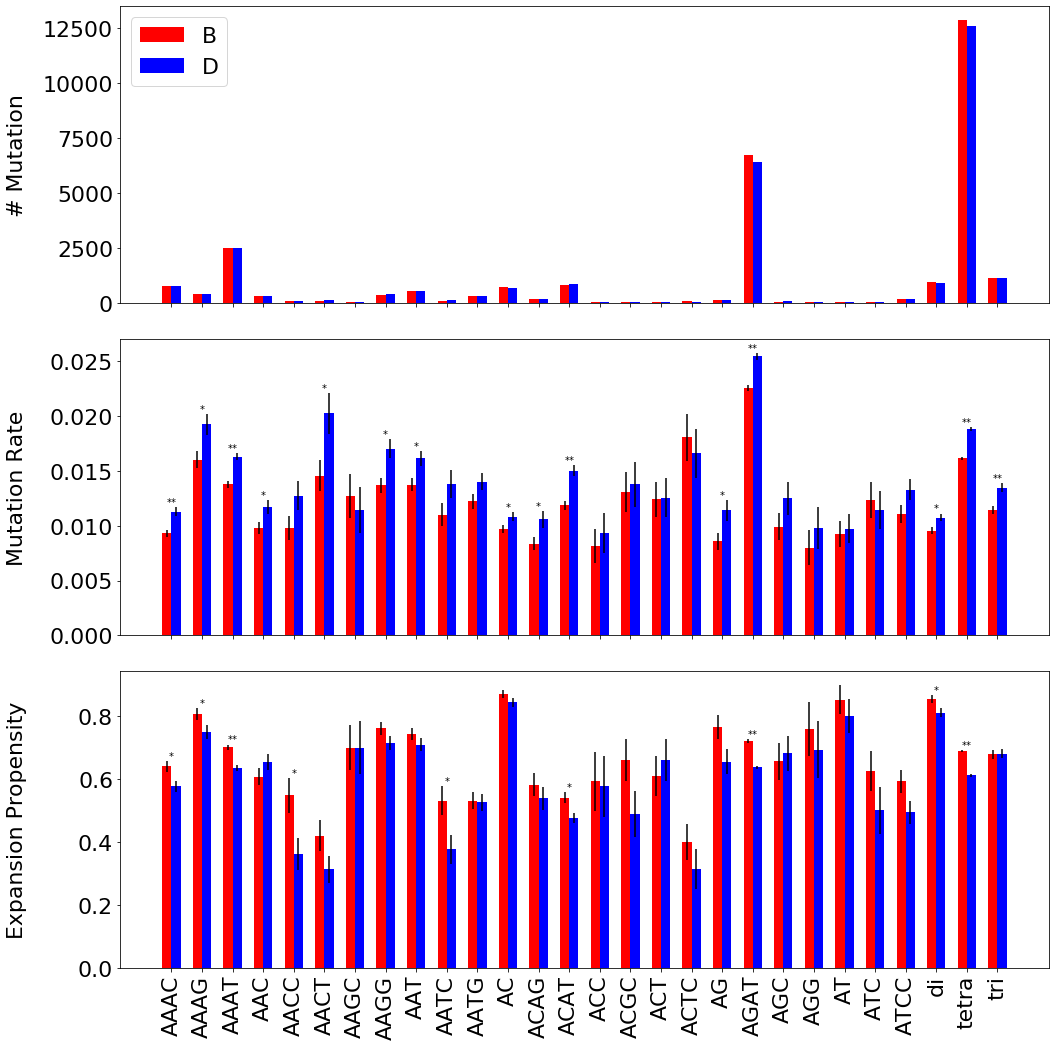

In [185]:
font = {'size'   : 22}
matplotlib.rc('font', **font)

labels = list(motif_df_all['motifs'])
rates_B = list(motif_df_all['rates_B'])
rates_D = list(motif_df_all['rates_D'])
nummut_B = list(motif_df_all['nummut_B'])
nummut_D = list(motif_df_all['nummut_D'])
experc_B = list(motif_df_all['experc_B'])
experc_D = list(motif_df_all['experc_D'])
calls_B = list(motif_df_all['calls_B'])
calls_D = list(motif_df_all['calls_D'])
# se_B = math.sqrt(perc_aggregate*(1-perc_aggregate)/n_total)
se_B = []
se_D = []
ztest_exp = []
for i in range(len(labels)):
    se_B.append(math.sqrt(experc_B[i]*(1-experc_B[i])/nummut_B[i]))
    se_D.append(math.sqrt(experc_D[i]*(1-experc_D[i])/nummut_D[i]))
    ztest_exp.append(proportions_ztest([nummut_B[i]*experc_B[i], nummut_D[i]*experc_D[i]], [nummut_B[i], nummut_D[i]]))

mutse_B = []
mutse_D = []
ztest_mut = []
for i in range(len(labels)):
    mutse_B.append(math.sqrt(rates_B[i]*(1-rates_B[i])/calls_B[i]))
    mutse_D.append(math.sqrt(rates_D[i]*(1-rates_D[i])/calls_D[i]))
    ztest_mut.append(proportions_ztest([nummut_B[i], nummut_D[i]], [calls_B[i], calls_D[i]]))



# fig = plt.figure()
fig, ax = plt.subplots(3, figsize=(15, 15))

# fig.set_size_inches((15, 5))
# ax1 = fig.add_subplot(111)
ax[0].bar(range(len(labels)), nummut_B, color="red", width=0.3, label='B')
ax[0].bar([item+0.3 for item in range(len(labels))], nummut_D, color="blue", width=0.3, label='D')
ax[0].set_xticks([x+0.15 for x in range(len(labels))])
# ax.set_xticklabels(labels, rotation=45);
ax[0].set(xticklabels=[])
ax[0].set_ylabel("# Mutation");
ax[0].legend()
ax[0].get_yaxis().set_label_coords(-0.1,0.5)

# fig = plt.figure()
# fig.set_size_inches((15, 5))
# ax2 = fig.add_subplot(111)
ax[1].bar(range(len(labels)), rates_B, color="red", width=0.3, label='B', yerr=mutse_B)
ax[1].bar([item+0.3 for item in range(len(labels))], rates_D, color="blue", width=0.3, label='D', yerr=mutse_D)
rects = ax[1].patches

pvals_annot = []
pvals = [x[1] for x in ztest_mut]
pvals_bonf = [x*len(pvals) for x in pvals]
for i in range(len(pvals)):
    if pvals_bonf[i] < 0.05:
        pvals_annot.append('**')
    elif pvals[i] < 0.05:
        pvals_annot.append('*')
    else:
        pvals_annot.append('')

rects_D = rects[1:]

for rect, rate_D, pval, l_height, annot_star in zip(rects, rates_D, pvals, mutse_D, pvals_annot):
#     print(rect, rect_D)
#     height = rect_D.get_height()
    height = rate_D
    ax[1].text(rect.get_x() + rect.get_width(), height+(l_height), annot_star , ha="center", va="bottom", fontsize=10)
#     ax.text(rect.get_x(), height+(l_height), annot_star , ha="center", va="bottom", fontsize=10)

    
ax[1].set_xticks([x+0.15 for x in range(len(labels))])
ax[1].set(xticklabels=[])
# ax.set_xticklabels(labels, rotation=45);
ax[1].set_ylabel("Mutation Rate");
# plt.legend()
ax[1].get_yaxis().set_label_coords(-0.1,0.5)


# fig = plt.figure()
# fig.set_size_inches((15, 5))
# ax[2] = fig.add_subplot(111)
ax[2].bar(range(len(labels)), experc_B, color="red", width=0.3, label='B', yerr=se_B)
ax[2].bar([item+0.3 for item in range(len(labels))], experc_D, color="blue", width=0.3, label='D', yerr=se_D)


rects = ax[2].patches

pvals_annot = []
pvals = [x[1] for x in ztest_exp]
pvals_bonf = [x*len(pvals) for x in pvals]
for i in range(len(pvals)):
    if pvals_bonf[i] < 0.05:
        pvals_annot.append('**')
    elif pvals[i] < 0.05:
        pvals_annot.append('*')
    else:
        pvals_annot.append('')

for rect, pval, l_height, annot_star in zip(rects, pvals, se_B, pvals_annot):
    height = rect.get_height()
    ax[2].text(rect.get_x() + rect.get_width(), height+(l_height), annot_star , ha="center", va="bottom", fontsize=10)

# ax.set_xticks(range(len(labels)))
ax[2].set_xticks([x+0.15 for x in range(len(labels))])

ax[2].set_xticklabels(labels, rotation=90);
ax[2].set_ylabel("Expansion Propensity");

ax[2].get_yaxis().set_label_coords(-0.1,0.5)
    
plt.tight_layout()
plt.savefig('figs/Motifs_RepeatLength_muttype.pdf', bbox_inches='tight') 


In [186]:
motif_df_all

,motifs,rates_B,rates_D,nummut_B,nummut_D,experc_B,experc_D,calls_B,calls_D
2,AAAC,0.009309,0.011279,768,781,0.640625,0.577465,82502,69244
5,AAAG,0.016025,0.019233,409,414,0.806846,0.748792,25523,21525
0,AAAT,0.013759,0.016278,2482,2487,0.700242,0.634499,180387,152783
0,AAC,0.009758,0.011729,326,329,0.607362,0.653495,33409,28051
12,AACC,0.009789,0.012729,84,91,0.547619,0.362637,8581,7149
3,AACT,0.014569,0.020240,100,118,0.420000,0.313559,6864,5830
13,AAGC,0.012751,0.011429,40,30,0.700000,0.700000,3137,2625
4,AAGG,0.013682,0.017027,380,403,0.760526,0.714640,27774,23668
1,AAT,0.013719,0.016140,537,533,0.743017,0.709193,39144,33023
9,AATC,0.011020,0.013836,111,117,0.531532,0.376068,10073,8456


## Sex chromosomes analysis

In [124]:
def expan_perc(group):
    expand_type = group['expand_type']
    num_expan = (expand_type == 'expan').sum()
    return num_expan/len(expand_type)

def num_B(group):
    gt = group['fou_gt_chr13']
    num_B = (gt == 'B').sum()
    return num_B

def num_D(group):
    gt = group['fou_gt_chr13']
    num_D = (gt == 'D').sum()
    return num_D

def num_B_founder(group):
    gt = group['founder']
    num_B = (gt == 'B').sum()
    return num_B

def num_D_founder(group):
    gt = group['founder']
    num_D = (gt == 'D').sum()
    return num_D

def num_BD_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_BD = ((gt == 'B')&(gt13 =='D')).sum()
    return num_BD

def num_DD_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_DD = ((gt == 'D')&(gt13 =='D')).sum()
    return num_DD

def num_BB_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_BB = ((gt == 'B')&(gt13 =='B')).sum()
    return num_BB

def num_DB_founder_gt13(group):
    gt = group['founder']
    gt13 = group['fou_gt_chr13']
    num_DB = ((gt == 'D')&(gt13 =='B')).sum()
    return num_DB

def num_expan(group):
    expand_type = group['expand_type']
    num_expan = (expand_type == 'expan').sum()
    return num_expan

def num_contr(group):
    expand_type = group['expand_type']
    num_contr = (expand_type == 'contr').sum()
    return num_contr

In [125]:
def create_master_df(df, motif_df, chr13_gt):
    num_mut = df.groupby(["chr", "pos"]).size().to_frame('num_mut')
    df_info = pd.merge(df, num_mut, on=['chr', 'pos'])

    df_info['mut_len'] = df_info.apply(lambda x: x.end - x.pos + 1, axis=1)
    df_info = pd.merge(df_info, motif_df[["chr","pos","end","motif","motif_len"]], on=["chr","pos","end"])

    df_info = pd.merge(df_info, chr13_gt[['strain', 'fou_gt']], on=['strain'])
    df_info.rename(columns = {'fou_gt_y':'fou_gt_chr13'}, inplace = True)

    grouped_mut = df_info.groupby(["chr", "pos"])
    expan_perc_df = grouped_mut.apply(expan_perc).to_frame('expan_perc')
    df_info = pd.merge(df_info, expan_perc_df, on=['chr', 'pos'])

    num_B_df = grouped_mut.apply(num_B).to_frame('num_B')
    df_info = pd.merge(df_info, num_B_df, on=['chr', 'pos'])
    num_D_df = grouped_mut.apply(num_D).to_frame('num_D')
    df_info = pd.merge(df_info, num_D_df, on=['chr', 'pos'])

    num_expan_df = grouped_mut.apply(num_expan).to_frame('num_expan')
    df_info = pd.merge(df_info, num_expan_df, on=['chr', 'pos'])
    num_contr_df = grouped_mut.apply(num_contr).to_frame('num_contr')
    df_info = pd.merge(df_info, num_contr_df, on=['chr', 'pos'])

    # expan_B, contr_B, expan_D, contr_D
    expan_dict = defaultdict(lambda: [0,0,0,0])
    for index, row in df_info.iterrows():
        pos = f"{row['chr']}_{row['pos']}"
        if row['fou_gt_chr13'] == 'B':
            if row['expand_type'] == 'expan':
                expan_dict[pos][0] += 1
            else:
                expan_dict[pos][1] += 1
        else:
            if row['expand_type'] == 'expan':
                expan_dict[pos][2] += 1
            else:
                expan_dict[pos][3] += 1
    
    df_info = df_info.drop(columns=['strain', 'expand_sign', 'expand_type', 'founder', 'fou_gt_chr13', 'RN_A', 'RN_B', 'delta_fou', 'fou_rn', 'fou_gt_x'])
    df_info = df_info.drop_duplicates()

    df_info['expan_B'] = 0
    df_info['contr_B'] = 0
    df_info['expan_D'] = 0
    df_info['contr_D'] = 0

    for index, row in df_info.iterrows():
        pos = f"{row['chr']}_{row['pos']}"
        df_info.at[index, 'expan_B'] = expan_dict[pos][0]
        df_info.at[index, 'contr_B'] = expan_dict[pos][1]
        df_info.at[index, 'expan_D'] = expan_dict[pos][2]
        df_info.at[index, 'contr_D'] = expan_dict[pos][3]
        
    return df_info

def calc_expan_propen(df):
    num_expan_B = 0
    num_mut_B = 0
    num_expan_D = 0
    num_mut_D = 0
    for index, row in df.iterrows():
        num_expan_B += row['expan_B']
        num_mut_B += row['num_B']
        num_expan_D += row['expan_D']
        num_mut_D += row['num_D']
        
    return num_expan_B/num_mut_B, num_mut_B, num_expan_D/num_mut_D, num_mut_D

In [126]:
X_info = create_master_df(X, motif_info, chr13_gt)
Y_info = create_master_df(Y, motif_info, chr13_gt)

In [128]:
experc_auto_B, num_mut_auto_B, experc_auto_D, num_mut_auto_D = calc_expan_propen(auto_info_collapsed)
experc_X_B, num_mut_X_B, experc_X_D, num_mut_X_D = calc_expan_propen(X_info)
experc_Y_B, num_mut_Y_B, experc_Y_D, num_mut_Y_D = calc_expan_propen(Y_info)

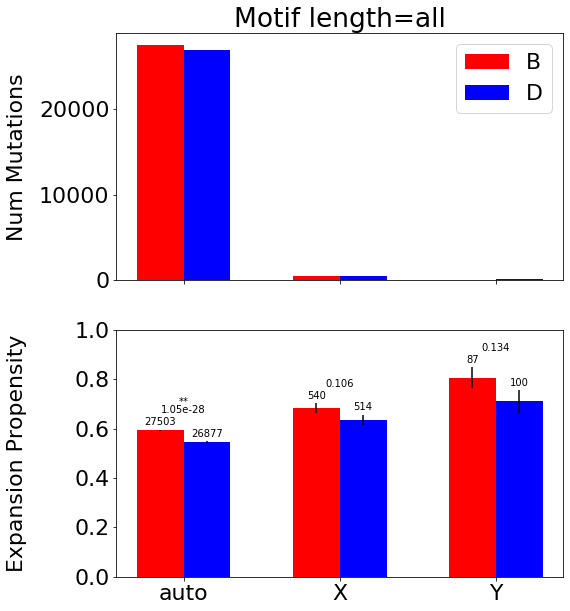

In [129]:
labels = ['auto', 'X', 'Y']

experc_B_all = [experc_auto_B, experc_X_B, experc_Y_B]
experc_D_all = [experc_auto_D, experc_X_D, experc_Y_D]
nummut_B_all = [num_mut_auto_B, num_mut_X_B, num_mut_Y_B]
nummut_D_all = [num_mut_auto_D, num_mut_X_D, num_mut_Y_D]
se_B = []
se_D = []
ztest_exp = []
for i in range(len(labels)):
    se_B.append(math.sqrt(experc_B_all[i]*(1-experc_B_all[i])/nummut_B_all[i]))
    se_D.append(math.sqrt(experc_D_all[i]*(1-experc_D_all[i])/nummut_D_all[i]))
    ztest_exp.append(proportions_ztest([nummut_B_all[i]*experc_B_all[i], nummut_D_all[i]*experc_D_all[i]], [nummut_B_all[i], nummut_D_all[i]]))


# fig = plt.figure()
# fig.set_size_inches((10, 5))
# ax = fig.add_subplot(111)
fig, ax = plt.subplots(2, figsize=(8, 10))

ax[0].bar(range(len(labels)), nummut_B_all, color="red", width=0.3, label='B')
ax[0].bar([item+0.3 for item in range(len(labels))], nummut_D_all, color="blue", width=0.3, label='D')
ax[0].set_xticks([x+0.15 for x in range(len(labels))])
ax[0].set(xticklabels=[])
# ax.set_xticklabels(labels);
ax[0].set_ylabel("Num Mutations");
ax[0].title.set_text('Motif length=all')
ax[0].legend()

ax[0].get_yaxis().set_label_coords(-0.2,0.5)

# fig = plt.figure()
# fig.set_size_inches((10, 5))
# ax = fig.add_subplot(111)
ax[1].bar(range(len(labels)), experc_B_all, color="red", width=0.3, label='B', yerr=se_B)
ax[1].bar([item+0.3 for item in range(len(labels))], experc_D_all, color="blue", width=0.3, label='D', yerr=se_D)
ax[1].set_ylim([0, 1])

rects = ax[1].patches

pvals_annot = []
pvals = [x[1] for x in ztest_exp]
pvals_bonf = [x*len(pvals) for x in pvals]
for i in range(len(pvals)):
    if pvals_bonf[i] < 0.05:
        pvals_annot.append('**')
    elif pvals[i] < 0.05:
        pvals_annot.append('*')
    else:
        pvals_annot.append('')
        
pvals = [x[1] for x in ztest_exp]
pvals[0] = f"{pvals[0]:.2e}"
pvals[1] = round(pvals[1], 3)
pvals[2] = round(pvals[2], 3)

for rect, pval, l_height, annot_star, nummut_B, nummut_D, se_B_h, se_D_h, h_D in zip(rects, pvals, [0.02,0.02,0.02], pvals_annot, nummut_B_all, nummut_D_all, se_B, se_D, experc_D_all):
    height = rect.get_height()
#     height = se
    ax[1].text(rect.get_x() + rect.get_width()/2, height+(se_B_h+0.01), nummut_B, ha="center", va="bottom", fontsize=10)
    ax[1].text(rect.get_x() + rect.get_width() + rect.get_width()/2, h_D+(se_D_h+0.01), nummut_D, ha="center", va="bottom", fontsize=10)
    ax[1].text(rect.get_x() + rect.get_width(), height+(se_B_h+0.06), pval, ha="center", va="bottom", fontsize=10)
    ax[1].text(rect.get_x() + rect.get_width(), height+(se_B_h+0.09), annot_star , ha="center", va="bottom", fontsize=10)
    
# ax[1].set_xticks(range(len(labels)))
ax[1].set_xticks([x+0.15 for x in range(len(labels))])
ax[1].set_xticklabels(labels);
ax[1].set_ylabel("Expansion Propensity");
# plt.legend()

ax[1].get_yaxis().set_label_coords(-0.2,0.5)

# plt.savefig('figs/ParentOrigin_all_v2.pdf', bbox_inches='tight') 



In [130]:

experc_auto_B, num_mut_auto_B, experc_auto_D, num_mut_auto_D = calc_expan_propen(auto_info[auto_info['motif_len']==4])
experc_X_B, num_mut_X_B, experc_X_D, num_mut_X_D = calc_expan_propen(X_info[X_info['motif_len']==4])
experc_Y_B, num_mut_Y_B, experc_Y_D, num_mut_Y_D = calc_expan_propen(Y_info[Y_info['motif_len']==4])

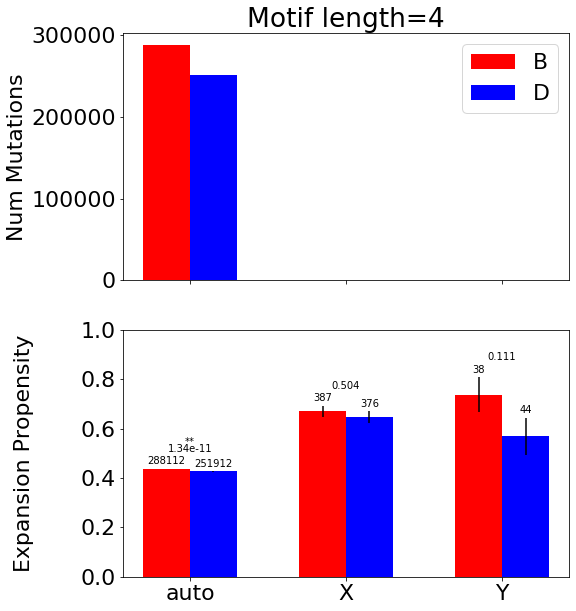

In [131]:
labels = ['auto', 'X', 'Y']

experc_B_all = [experc_auto_B, experc_X_B, experc_Y_B]
experc_D_all = [experc_auto_D, experc_X_D, experc_Y_D]
nummut_B_all = [num_mut_auto_B, num_mut_X_B, num_mut_Y_B]
nummut_D_all = [num_mut_auto_D, num_mut_X_D, num_mut_Y_D]
se_B = []
se_D = []
ztest_exp = []
for i in range(len(labels)):
    se_B.append(math.sqrt(experc_B_all[i]*(1-experc_B_all[i])/nummut_B_all[i]))
    se_D.append(math.sqrt(experc_D_all[i]*(1-experc_D_all[i])/nummut_D_all[i]))
    ztest_exp.append(proportions_ztest([nummut_B_all[i]*experc_B_all[i], nummut_D_all[i]*experc_D_all[i]], [nummut_B_all[i], nummut_D_all[i]]))

# fig = plt.figure()
# fig.set_size_inches((10, 5))
# ax = fig.add_subplot(111)

fig, ax = plt.subplots(2, figsize=(8, 10))

ax[0].bar(range(len(labels)), nummut_B_all, color="red", width=0.3, label='B')
ax[0].bar([item+0.3 for item in range(len(labels))], nummut_D_all, color="blue", width=0.3, label='D')
ax[0].set_xticks([x+0.15 for x in range(len(labels))])
ax[0].set(xticklabels=[])
# ax.set_xticklabels(labels);
ax[0].set_ylabel("Num Mutations");
ax[0].title.set_text('Motif length=4')
ax[0].legend()
ax[1].get_yaxis().set_label_coords(-0.2,0.5)


# fig = plt.figure()
# fig.set_size_inches((10, 5))
# ax = fig.add_subplot(111)
ax[1].bar(range(len(labels)), experc_B_all, color="red", width=0.3, label='B', yerr=se_B)
ax[1].bar([item+0.3 for item in range(len(labels))], experc_D_all, color="blue", width=0.3, label='D', yerr=se_D)
ax[1].set_ylim([0, 1])

rects = ax[1].patches

pvals_annot = []
pvals = [x[1] for x in ztest_exp]
pvals_bonf = [x*len(pvals) for x in pvals]
for i in range(len(pvals)):
    if pvals_bonf[i] < 0.05:
        pvals_annot.append('**')
    elif pvals[i] < 0.05:
        pvals_annot.append('*')
    else:
        pvals_annot.append('')

pvals[0] = f"{pvals[0]:.2e}"
pvals[1] = round(pvals[1], 3)
pvals[2] = round(pvals[2], 3)

for rect, pval, l_height, annot_star, nummut_B, nummut_D, se_B_h, se_D_h, h_D in zip(rects, pvals, [0.02,0.02,0.02], pvals_annot, nummut_B_all, nummut_D_all, se_B, se_D, experc_D_all):
    height = rect.get_height()
#     height = se
    ax[1].text(rect.get_x() + rect.get_width()/2, height+(se_B_h+0.01), nummut_B, ha="center", va="bottom", fontsize=10)
    ax[1].text(rect.get_x() + rect.get_width() + rect.get_width()/2, h_D+(se_D_h+0.01), nummut_D, ha="center", va="bottom", fontsize=10)
    ax[1].text(rect.get_x() + rect.get_width(), height+(se_B_h+0.06), pval, ha="center", va="bottom", fontsize=10)
    ax[1].text(rect.get_x() + rect.get_width(), height+(se_B_h+0.09), annot_star , ha="center", va="bottom", fontsize=10)


ax[1].set_xticks([x+0.15 for x in range(len(labels))])
ax[1].set_xticklabels(labels);
ax[1].set_ylabel("Expansion Propensity");
# plt.legend()
ax[1].get_yaxis().set_label_coords(-0.2,0.5)

# plt.savefig('figs/ParentOrigin_4_v2.pdf', bbox_inches='tight') 

